In [1]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class RNN_base(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation):
        super().__init__()
        sigma = 0.01
        self.W_xh = nn.Parameter(torch.randn(input_size, hidden_size)*sigma)
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size)*sigma) 
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        self.activation = activation
        self.W_hq = nn.Parameter(torch.randn(hidden_size, output_size)*sigma)
        self.b_q = nn.Parameter(torch.zeros(output_size))
    
    def forward(self, X, state=None):
        if state is None:
            state = torch.zeros(X.shape[1], self.W_hh.shape[0], device=X.device)
        outputs = []
        states = []
        for Xt in X:  #X is the input with shape (seq_len, batch_size, input_size)
            state = self.activation(Xt @ self.W_xh + state @ self.W_hh + self.b_h)
            states.append(state)
            output = state @ self.W_hq + self.b_q
            outputs.append(output)
        return outputs, states    

    @property
    def device(self):
        return next(self.parameters()).device

In [4]:
class RNN_lstm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        sigma = 0.01
        self.W_xi = nn.Parameter(torch.randn(input_size, hidden_size)*sigma)
        self.W_xf = nn.Parameter(torch.randn(input_size, hidden_size)*sigma)
        self.W_xo = nn.Parameter(torch.randn(input_size, hidden_size)*sigma)
        self.W_xg = nn.Parameter(torch.randn(input_size, hidden_size)*sigma)

        self.W_hi = nn.Parameter(torch.randn(hidden_size, hidden_size)*sigma)
        self.W_hf = nn.Parameter(torch.randn(hidden_size, hidden_size)*sigma)
        self.W_ho = nn.Parameter(torch.randn(hidden_size, hidden_size)*sigma)
        self.W_hg = nn.Parameter(torch.randn(hidden_size, hidden_size)*sigma)

        self.b_i = nn.Parameter(torch.zeros(hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))
        self.b_g = nn.Parameter(torch.zeros(hidden_size))

        self.W_hq = nn.Parameter(torch.randn(hidden_size, output_size)*sigma)
        self.b_q = nn.Parameter(torch.zeros(output_size))

    def forward(self, X, state=None):
        if state is None:
            # Hidden state and cell state
            state = (torch.zeros(X.shape[1], self.W_xi.shape[1], device=X.device), torch.zeros(X.shape[1], self.W_xi.shape[1], device=X.device))
        
        outputs = []
        states = []
        for Xt in X:
            H, C = state
            I = torch.sigmoid(Xt @ self.W_xi + H @ self.W_hi + self.b_i)
            F = torch.sigmoid(Xt @ self.W_xf + H @ self.W_hf + self.b_f)
            O = torch.sigmoid(Xt @ self.W_xo + H @ self.W_ho + self.b_o)
            G = torch.tanh(Xt @ self.W_xg + H @ self.W_hg + self.b_g)
            C = F * C + I * G
            H = O * torch.tanh(C)
            state = H, C
            states.append((state))
            output = H @ self.W_hq + self.b_q
            outputs.append(output)
        return outputs, states

    @property
    def device(self):
        return next(self.parameters()).device


In [5]:
class RNN_gru(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        sigma = 0.01
        self.W_xr = nn.Parameter(torch.randn(input_size, hidden_size)*sigma)
        self.W_xu = nn.Parameter(torch.randn(input_size, hidden_size)*sigma)
        self.W_xh = nn.Parameter(torch.randn(input_size, hidden_size)*sigma)

        self.W_hr = nn.Parameter(torch.randn(hidden_size, hidden_size)*sigma)
        self.W_hu = nn.Parameter(torch.randn(hidden_size, hidden_size)*sigma)
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size)*sigma)

        self.b_r = nn.Parameter(torch.zeros(hidden_size))
        self.b_u = nn.Parameter(torch.zeros(hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

        self.W_hq = nn.Parameter(torch.randn(hidden_size, output_size)*sigma)
        self.b_q = nn.Parameter(torch.zeros(output_size))

    def forward(self, X, state=None):
        if state is None:
            state = torch.zeros(X.shape[1], self.W_xh.shape[1], device=X.device)

        outputs = []
        states = []
        for Xt in X:
            R = torch.sigmoid(Xt @ self.W_xr + state @ self.W_hr + self.b_r)
            U = torch.sigmoid(Xt @ self.W_xu + state @ self.W_hu + self.b_u)
            H = torch.tanh(Xt @ self.W_xh + (state * R) @ self.W_hh + self.b_h)
            state = U * state + (1 - U) * H
            states.append(state)
            outputs.append(state @ self.W_hq + self.b_q)
        return outputs, states

    @property
    def device(self):
        return next(self.parameters()).device

In [6]:
ds_text = ''
with open('tinyshakespeare.txt', 'r') as f:
    ds_text = f.read()
    ds_text = ds_text.lower() # convert to lowercase to make training easier
print("dataset size:", len(ds_text))


dataset size: 1115394


In [7]:
vocab = sorted(set(ds_text))
print(f"Vocabulary size: {len(vocab)}")
char_to_idx = {char:idx for idx, char in enumerate(vocab)}
idx_to_char = {idx:char for char, idx in char_to_idx.items()}

Vocabulary size: 39


In [8]:
corpus_indices = torch.tensor([char_to_idx[char] for char in ds_text])
corpus_indices

tensor([18, 21, 30,  ..., 19,  8,  0])

In [9]:
encoded_text = torch.zeros(len(ds_text), len(vocab))
for i, char in enumerate(ds_text):
    encoded_text[i, char_to_idx[char]] = 1
encoded_text

#Or in an optimized way
#encoded_text = nn.functional.one_hot(corpus_indices).float()    

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [10]:
class DataLoader():
    def __init__(self, corpus_indices, encoded_text, seq_length, batch_size):
        self.corpus_indices = corpus_indices
        self.encoded_text = encoded_text
        self.seq_length = seq_length
        self.batch_size = batch_size
    
    def __iter__(self):
        num_examples = (self.encoded_text.shape[0] - 1) // self.seq_length #-1 to avoid OOB for Y (j+1, j+seq_length+1) 
        #starting points
        example_indices = list(range(0, num_examples * self.seq_length, self.seq_length))
        random.shuffle(example_indices)
        
        for i in range(0, len(example_indices), self.batch_size):
            batch_indices = example_indices[i : i + self.batch_size]
            # if the batch is smaller than the batch size, we drop it
            if len(batch_indices) < self.batch_size:
                continue
            
            X = torch.stack([self.encoded_text[j : j + self.seq_length] for j in batch_indices])
            Y = torch.stack([self.corpus_indices[j + 1 : j + self.seq_length + 1] for j in batch_indices])
            
            # Transpose to (seq_length, batch_size, vocab_size)
            yield X.transpose(0, 1), Y.transpose(0, 1)

    def __len__(self):
        num_examples = (self.encoded_text.shape[0] - 1) // self.seq_length
        return num_examples // self.batch_size


In [11]:
class Training():
    def __init__(self, model, data_loader, optimizer, epochs, grad_clip=1.0):
        self.model = model
        self.data_loader = data_loader
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optimizer
        self.epochs = epochs
        self.grad_clip = grad_clip

    def predict(self, prefix, num_preds, vocab, char_to_idx, idx_to_char):
        state = None
        outputs = [char_to_idx[prefix[0]]]
        def get_input():
            return torch.tensor([outputs[-1]], device=self.model.device).reshape(1, 1)
        
        with torch.no_grad():
            # Warm up with prefix
            for char in prefix[1:]:
                X = nn.functional.one_hot(get_input(), num_classes=len(vocab)).float()
                _, states = self.model(X, state)
                state = states[-1]
                outputs.append(char_to_idx[char])
            
            # Predict num_preds characters
            for _ in range(num_preds):
                X = nn.functional.one_hot(get_input(), num_classes=len(vocab)).float()
                y, states = self.model(X, state)
                state = states[-1]
                outputs.append(int(y[0].argmax(dim=1).item()))
            
        return ''.join([idx_to_char[i] for i in outputs])

    def train(self):
        self.model.to(self.model.device)
        losses = []
        for epoch in range(1, self.epochs + 1):
            total_loss = 0
            for X, Y in self.data_loader:
                X, Y = X.to(self.model.device), Y.to(self.model.device)
                
                y_hat, _ = self.model(X)
                y_hat = torch.stack(y_hat).reshape(-1, y_hat[0].shape[-1])
                Y = Y.reshape(-1)
                
                loss = self.criterion(y_hat, Y.long())
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
                self.optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(self.data_loader)
            losses.append(avg_loss)
            print(f"Epoch {epoch} loss: {avg_loss}")
            print(f"Sample: {self.predict('the ', 50, vocab, char_to_idx, idx_to_char)}")
        return losses


Benchmarking Vanilla RNN
Epoch 1 loss: 2.869382870547912
Sample: the the the the the the the the the the the the the th
Epoch 2 loss: 2.445843803531983
Sample: the the the the the the the the the the the the the th
Epoch 3 loss: 2.3276417816386505
Sample: the the the the the the the the the the the the the th
Epoch 4 loss: 2.273286845754175
Sample: the sore the the the the the the the the the the the t
Epoch 5 loss: 2.241597172968528
Sample: the sore the sore the sore the sore the sore the sore 
Epoch 6 loss: 2.21544189926456
Sample: the sore the the the the the the the the the the the t
Epoch 7 loss: 2.193884312229998
Sample: the the the the the the the the the the the the the th
Epoch 8 loss: 2.1723230980774937
Sample: the the the the the the the the the the the the the th
Epoch 9 loss: 2.1493383619715187
Sample: the soul the the the the the the the the the the the t
Epoch 10 loss: 2.124602835844545
Sample: the sore the seath the sore the seath the sore the sea
Time taken: 102.20 se

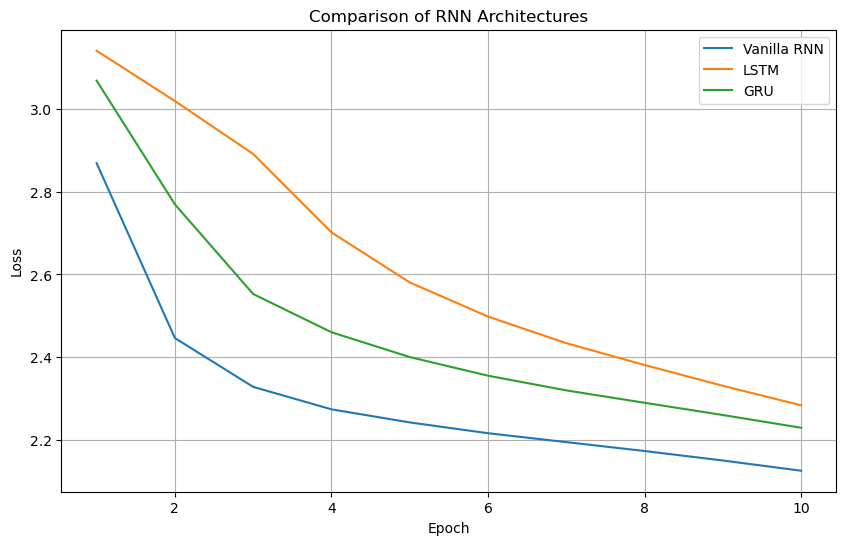

In [13]:
import time
import matplotlib.pyplot as plt

def benchmark_models(models_to_test, epochs=5):
    results = {}
    num_hiddens = 1028
    seq_length = 128
    batch_size = 32
    lr = 0.5
    
    data_loader = DataLoader(corpus_indices, encoded_text, seq_length, batch_size)
    
    plt.figure(figsize=(10, 6))
    
    for name, model_class, extra_args in models_to_test:
        print(f"\n{'='*20}\nBenchmarking {name}\n{'='*20}")
        
        model = model_class(len(vocab), num_hiddens, len(vocab), *extra_args)
        model.to(device)
        
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        trainer = Training(model, data_loader, optimizer, epochs)
        
        start_time = time.time()
        losses = trainer.train()
        end_time = time.time()
        
        results[name] = {
            'time': end_time - start_time,
            'losses': losses
        }
        print(f"Time taken: {end_time - start_time:.2f} seconds")
        plt.plot(range(1, epochs + 1), losses, label=name)
        
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Comparison of RNN Architectures')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results

models_config = [
    ("Vanilla RNN", RNN_base, [nn.Tanh()]),
    ("LSTM", RNN_lstm, []),
    ("GRU", RNN_gru, [])
]

benchmark_results = benchmark_models(models_config, epochs=10)